In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import scipy.stats as stats

import random

In [15]:
df = pd.read_csv(r'D:\ds_ridwan\ab_testing_project\marketing_AB.csv',index_col=False)
df.head(3)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18


In [16]:
# Dropping cols Unnamed
df = df.drop(columns=['Unnamed: 0'])

In [4]:
# Count the number of duplicates
n_duplicates = df.duplicated().sum()

# Print the results
print(n_duplicates)

0


# Quick Look a Data

In [5]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

In [6]:
summary(df)

data shape: (588101, 6)


,data type,#missing,%missing,#unique,min,max
user id,int64,0,0.0,588101,900000.0,1654483.0
test group,object,0,0.0,2,NaN,NaN
converted,bool,0,0.0,2,NaN,NaN
total ads,int64,0,0.0,807,1.0,2065.0
most ads day,object,0,0.0,7,NaN,NaN
most ads hour,int64,0,0.0,24,0.0,23.0


In [9]:
# select numerical and categorical variables respectively.
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols.remove('user id')

In [12]:
df.dtypes

user id           int64
test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

# Exploratory Data Analysis

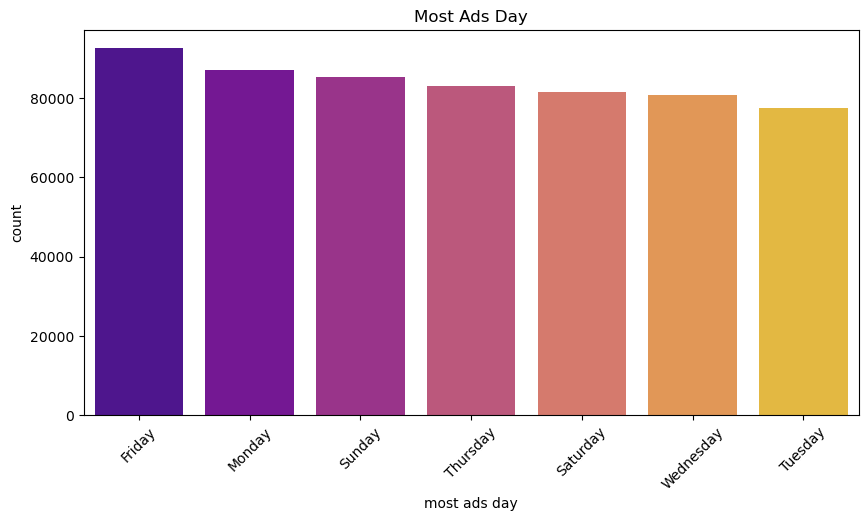

In [22]:
# Membuat plot untuk 'most ads day'
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='most ads day', order=df['most ads day'].value_counts().index, palette='plasma')
plt.title('Most Ads Day')
plt.xticks(rotation=45)
plt.show()

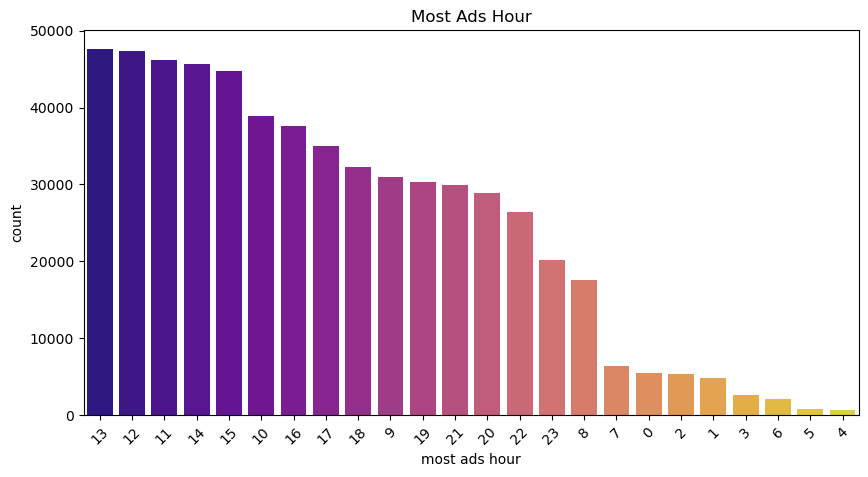

In [23]:
# Membuat plot untuk 'most ads hour'
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='most ads hour', order=df['most ads hour'].value_counts().index, palette='plasma')
plt.title('Most Ads Hour')
plt.xticks(rotation=45)
plt.show()

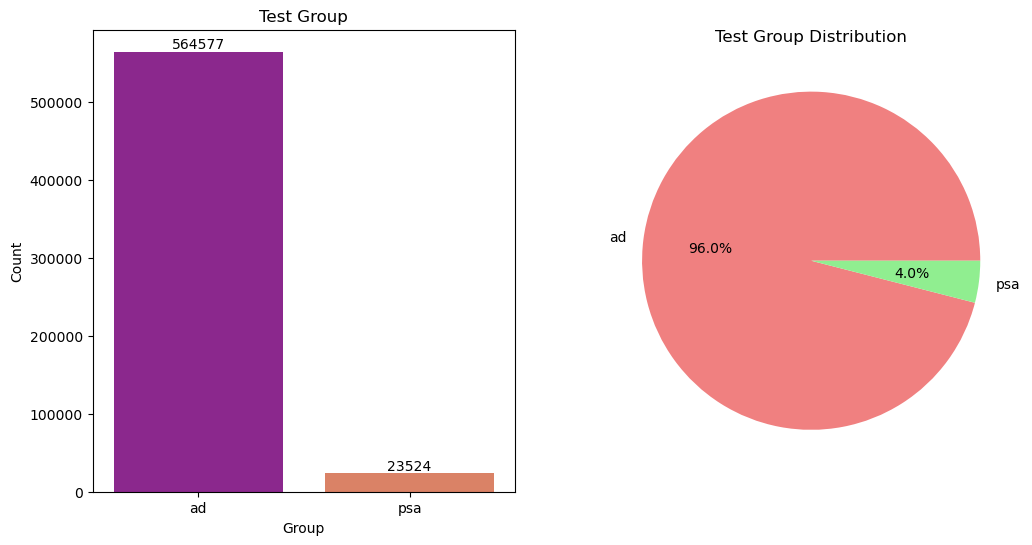

In [24]:
# Plot bar untuk 'test group' dengan frekuensi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='test group', palette='plasma')
plt.title('Test Group')
plt.xlabel('Group')
plt.ylabel('Count')
for i in range(2):
    total = df['test group'].value_counts()[i]
    plt.text(i, total, str(total), ha='center', va='bottom')

# Plot pie untuk 'test group' dengan presentase
plt.subplot(1, 2, 2)
group_counts = df['test group'].value_counts()
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Test Group Distribution')

plt.show()

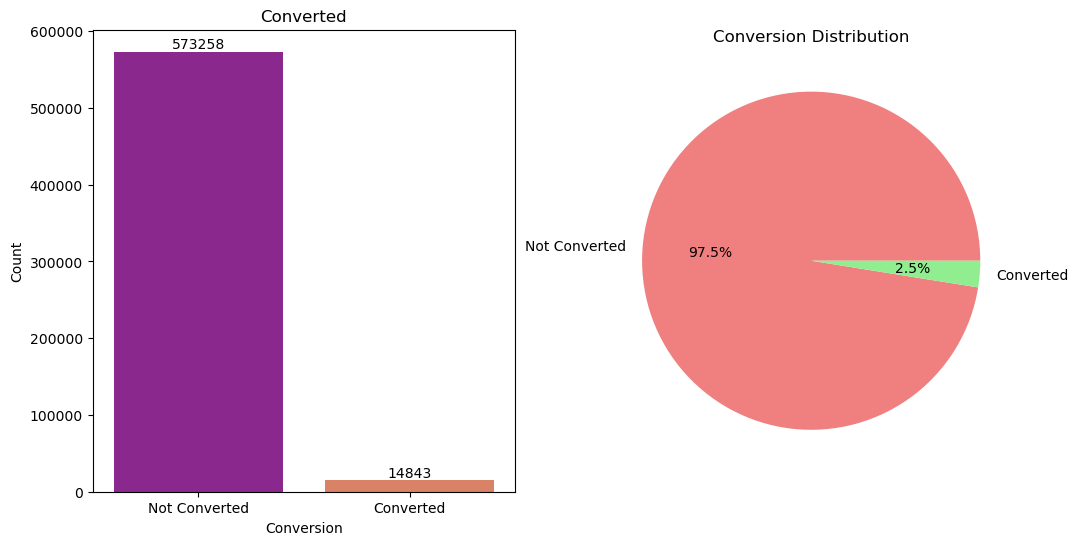

In [26]:
# Plot bar untuk 'converted' dengan frekuensi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='converted', palette='plasma')
plt.title('Converted')
plt.xticks([0, 1], ['Not Converted', 'Converted'])
plt.xlabel('Conversion')
plt.ylabel('Count')
for i in range(2):
    total = df['converted'].value_counts()[i]
    plt.text(i, total, str(total), ha='center', va='bottom')

# Plot pie untuk 'converted' dengan presentase
plt.subplot(1, 2, 2)
converted_counts = df['converted'].value_counts()
plt.pie(converted_counts, labels=['Not Converted', 'Converted'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Conversion Distribution')

plt.show()

# *A/B Testing*

In [23]:
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.proportion as sms

In [10]:
# Tingkat signifikansi (α), power level (1 - β) serta Difference between control & treatment (δ)
alpha = 0.05
power = 0.80
effect_size = 0.01  

In [9]:
df['test group'].value_counts()

test group
ad     564577
psa     23524
Name: count, dtype: int64

In [10]:
df['converted'].value_counts()

converted
False    573258
True      14843
Name: count, dtype: int64

In [11]:
# Bagi data menjadi kelompok kontrol (PSA) dan perlakuan (ads)
control_group = df[df['test group'] == 'psa']
treatment_group = df[df['test group'] == 'ad']

In [12]:

# Hitung konversi pengguna di masing-masing kelompok
conversion_control = control_group['converted'].sum()
conversion_treatment = treatment_group['converted'].sum()

# Hitung ukuran sampel di masing-masing kelompok
n_control = len(control_group)
n_treatment = len(treatment_group)

In [13]:
n_control

23524

In [14]:
n_treatment

564577

In [16]:
# Standar deviasi dari tingkat konversi (estimasi dari data atau asumsi)
std_dev = np.sqrt((conversion_control / n_control) * (1 - conversion_control / n_control))
std_dev

0.13242106074016824

In [18]:
# Hitung ukuran sampel yang dibutuhkan
power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power,
                                         alternative='larger')
sample_size

4946.7223664872145

In [19]:
# Lakukan uji statistik (t-test) untuk menentukan apakah perbedaan signifikan
t_stat, p_value = stats.ttest_ind(control_group['converted'], treatment_group['converted'])

# Output hasil uji statistik
print(f'Test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Analisis hasil uji statistik
if p_value < alpha:
    print('Terdapat perbedaan yang signifikan antara kelompok kontrol dan kelompok treatment.')
else:
    print('Tidak ada perbedaan signifikan antara kelompok kontrol dan kelompok treatment.')

Test Statistic: -7.37040597428566
P-value: 1.7033052627831264e-13
Terdapat perbedaan yang signifikan antara kelompok kontrol dan kelompok treatment.


### Conf-interval

In [33]:
# Hitung proporsi gabungan (p_pooled) dari kedua kelompok
total_converted = conversion_control + conversion_treatment
total_observed = n_control + n_treatment
p_pooled = total_converted / total_observed

In [34]:
# Proporsi konversi dalam kelompok kontrol
p_control = df[df['test group'] == 'psa']['converted'].mean()

# Proporsi konversi dalam kelompok perlakuan
p_treatment = df[df['test group'] == 'ad']['converted'].mean()

# Hitung ukuran sampel kelompok kontrol dan kelompok perlakuan
n_control = len(df[df['test group'] == 'psa'])
n_treatment = len(df[df['test group'] == 'ad'])

z_alpha = stats.norm.ppf(1 - alpha/2)
conf_int_lower = p_treatment - z_alpha * np.sqrt(p_pooled * (1 - p_pooled) / (n_control + n_treatment))
conf_int_upper = p_treatment + z_alpha * np.sqrt(p_pooled * (1 - p_pooled) / (n_control + n_treatment))

# Output confidence interval
print(f'Confidence Interval: {conf_int_lower:.3f} - {conf_int_upper:.3f}')

Confidence Interval: 0.025 - 0.026


### SRM With Chi-square test

In [36]:
# Data konversi dalam kelompok kontrol (PSA)
control_converted = df[df['test group'] == 'psa']['converted']

# Data konversi dalam kelompok perlakuan (Ads)
treatment_converted = df[df['test group'] == 'ad']['converted']

# Membuat tabel kontingensi (contingency table)
contingency_table = pd.crosstab(df['test group'], df['converted'])

# Melakukan chi-square test
chi2, p_chi2, _, _ = stats.chi2_contingency(contingency_table)

# Output hasil chi-square test
print(f'Chi-square Statistic: {chi2:.4f}')
print(f'P-value (Chi-square): {p_chi2:.4f}')

# Analisis hasil
alpha = 0.05

if p_chi2 < alpha:
    print('Hipotesis Nol (H0) ditolak: Terdapat perbedaan yang signifikan antara kelompok kontrol dan kelompok perlakuan dalam hal konversi pengguna.')
else:
    print('Tidak cukup bukti untuk menolak Hipotesis Nol (H0). Tidak ada perbedaan signifikan antara kelompok kontrol dan kelompok perlakuan dalam hal konversi pengguna.')


Chi-square Statistic: 54.0058
P-value (Chi-square): 0.0000
Hipotesis Nol (H0) ditolak: Terdapat perbedaan yang signifikan antara kelompok kontrol dan kelompok perlakuan dalam hal konversi pengguna.


In [5]:
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

### Hypotesis testing

In [6]:
# Data konversi dalam kelompok kontrol (PSA)
control_converted = df[df['test group'] == 'psa']['converted']

# Data konversi dalam kelompok perlakuan (Ads)
treatment_converted = df[df['test group'] == 'ad']['converted']

# Hitung jumlah pengamatan dalam masing-masing kelompok
n_control = len(control_converted)
n_treatment = len(treatment_converted)

# Hitung jumlah pengamatan yang mengkonversi dalam masing-masing kelompok
count_control = control_converted.sum()
count_treatment = treatment_converted.sum()

# Z-proportion test (Two-sample proportions Z-test)
z_stat, p_z = proportions_ztest([count_control, count_treatment], [n_control, n_treatment])

In [8]:
print(f'Z-statistic (Z-proportion): {z_stat:.4f}')
print(f'P-value (Z-proportion): {p_z:.4f}')

Z-statistic (Z-proportion): -7.3701
P-value (Z-proportion): 0.0000


In [13]:
# Analisa hasil
if p_z < alpha:
    print('Hasil z-proportion test menunjukkan terdapat perbedaan yang signifikan antara kelompok kontrol dan kelompok treatment.')
else:
    print('Tidak ada perbedaan signifikan antara kelompok kontrol dan kelompok treatment berdasarkan z-proportion test.')

Hasil z-proportion test menunjukkan terdapat perbedaan yang signifikan antara kelompok kontrol dan kelompok treatment.


In [19]:
df.columns

Index(['user id', 'test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

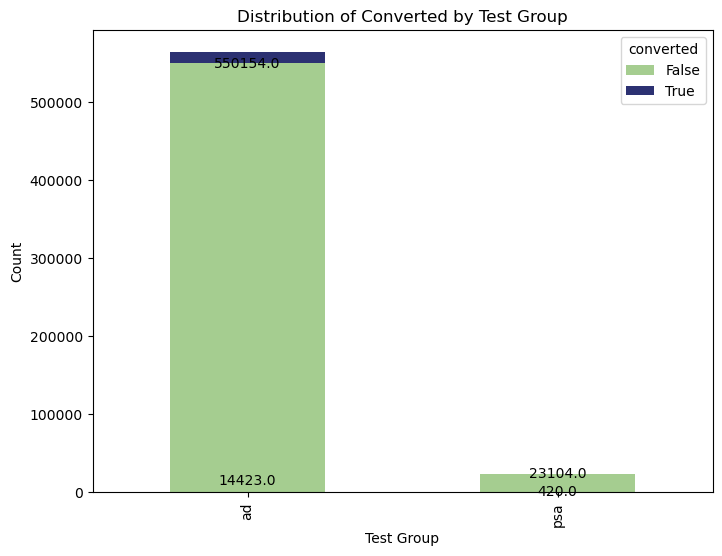

In [27]:
# Mengelompokkan data dan menghitung frekuensi setiap kombinasi
grouped_counts = df.groupby(['test group', 'converted']).size().unstack()

# Membuat barplot dengan colormap 'plasma'
ax = grouped_counts.plot(kind='bar', stacked=True, cmap='crest', figsize=(8, 6))

# Menambahkan label count di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Memberikan judul dan label sumbu
plt.title('Distribution of Converted by Test Group')
plt.xlabel('Test Group')
plt.ylabel('Count')

# Menampilkan plot
plt.show()
